In [1]:
import hashlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandahouse as ph
import scipy as sp
import seaborn as sns

# Соединение с ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database': 'simulator_20221220',
    'user': 'student',
    'password': 'dpo_python_2020'
}

# Запрос
query_03 = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-12-02' AND '2022-12-08'
    AND exp_group in (0, 3)
GROUP BY exp_group, user_id
"""

query_12 = """
SELECT
    exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2022-12-02' AND '2022-12-08'
    AND exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

# Загрузить данные
df03 = ph.read_clickhouse(query_03, connection=connection)
df12 = ph.read_clickhouse(query_12, connection=connection)
df03.sort_values(['exp_group', 'user_id'], inplace=True)
df12.sort_values(['exp_group', 'user_id'], inplace=True)

print('Группы 0 3\n', df03, '\n')
print('Группы 1 2\n', df12, '\n')


Группы 0 3
        exp_group  user_id  likes  views       ctr
8256           0      201     16     62  0.258065
12209          0      212      7     27  0.259259
7902           0      222      2     12  0.166667
19293          0      235     27    126  0.214286
9105           0      239     14     47  0.297872
...          ...      ...    ...    ...       ...
13236          3   140457      3     14  0.214286
17102          3   140479     16     60  0.266667
9956           3   140480      7     15  0.466667
10056          3   140485      8     21  0.380952
507            3   140489     12     56  0.214286

[20048 rows x 5 columns] 

Группы 1 2
        exp_group  user_id  likes  views       ctr
15545          1      206      6     38  0.157895
14471          1      216      3     27  0.111111
6368           1      243     15     95  0.157895
4433           1      274     16    102  0.156863
5060           1      276     11     32  0.343750
...          ...      ...    ...    ...       ..

In [2]:
# Загрузить данные
df03 = ph.read_clickhouse(query_03, connection=connection)
df12 = ph.read_clickhouse(query_12, connection=connection)
df03.sort_values(['exp_group', 'user_id'], inplace=True)
df12.sort_values(['exp_group', 'user_id'], inplace=True)

# Получить данные для каждой группы
group0_df = df03[df03.exp_group == 0].copy()
group3_df = df03[df03.exp_group == 3].copy()
group1_df = df12[df12.exp_group == 1].copy()
group2_df = df12[df12.exp_group == 2].copy()

# Рассчитать ОБЩИЙ CTR для контрольных групп №0, №1
group0_ctr = group0_df.likes.sum() / group0_df.views.sum()
group1_ctr = group1_df.likes.sum() / group1_df.views.sum()

# Рассчитать линеаризованные лайки
group0_df['linearized_likes'] = group0_df.likes - group0_ctr * group0_df.views
group3_df['linearized_likes'] = group3_df.likes - group0_ctr * group3_df.views
group1_df['linearized_likes'] = group1_df.likes - group1_ctr * group1_df.views
group2_df['linearized_likes'] = group2_df.likes - group1_ctr * group2_df.views

# Проверка полученных данных
print('ГРУППА 0:\n', group0_df, '\n')
print('ГРУППА 3:\n', group3_df, '\n')
print('ГРУППА 1:\n', group1_df, '\n')
print('ГРУППА 2:\n', group2_df, '\n')


ГРУППА 0:
        exp_group  user_id  likes  views       ctr  linearized_likes
8256           0      201     16     62  0.258065          3.089360
12209          0      212      7     27  0.259259          1.377625
7902           0      222      2     12  0.166667         -0.498833
19293          0      235     27    126  0.214286          0.762249
9105           0      239     14     47  0.297872          4.212902
...          ...      ...    ...    ...       ...               ...
13116          0   140453      2     20  0.100000         -2.164722
6413           0   140464     13     69  0.188406         -1.368292
16895          0   140467      6     53  0.113208         -5.036514
8890           0   140483      4     35  0.114286         -3.288264
19123          0   140487      3     11  0.272727          0.709403

[9999 rows x 6 columns] 

ГРУППА 3:
        exp_group  user_id  likes  views       ctr  linearized_likes
12329          3      200      5     16  0.312500          1.668222

# Визуальный анализ

Text(0, 0.5, 'Количество')

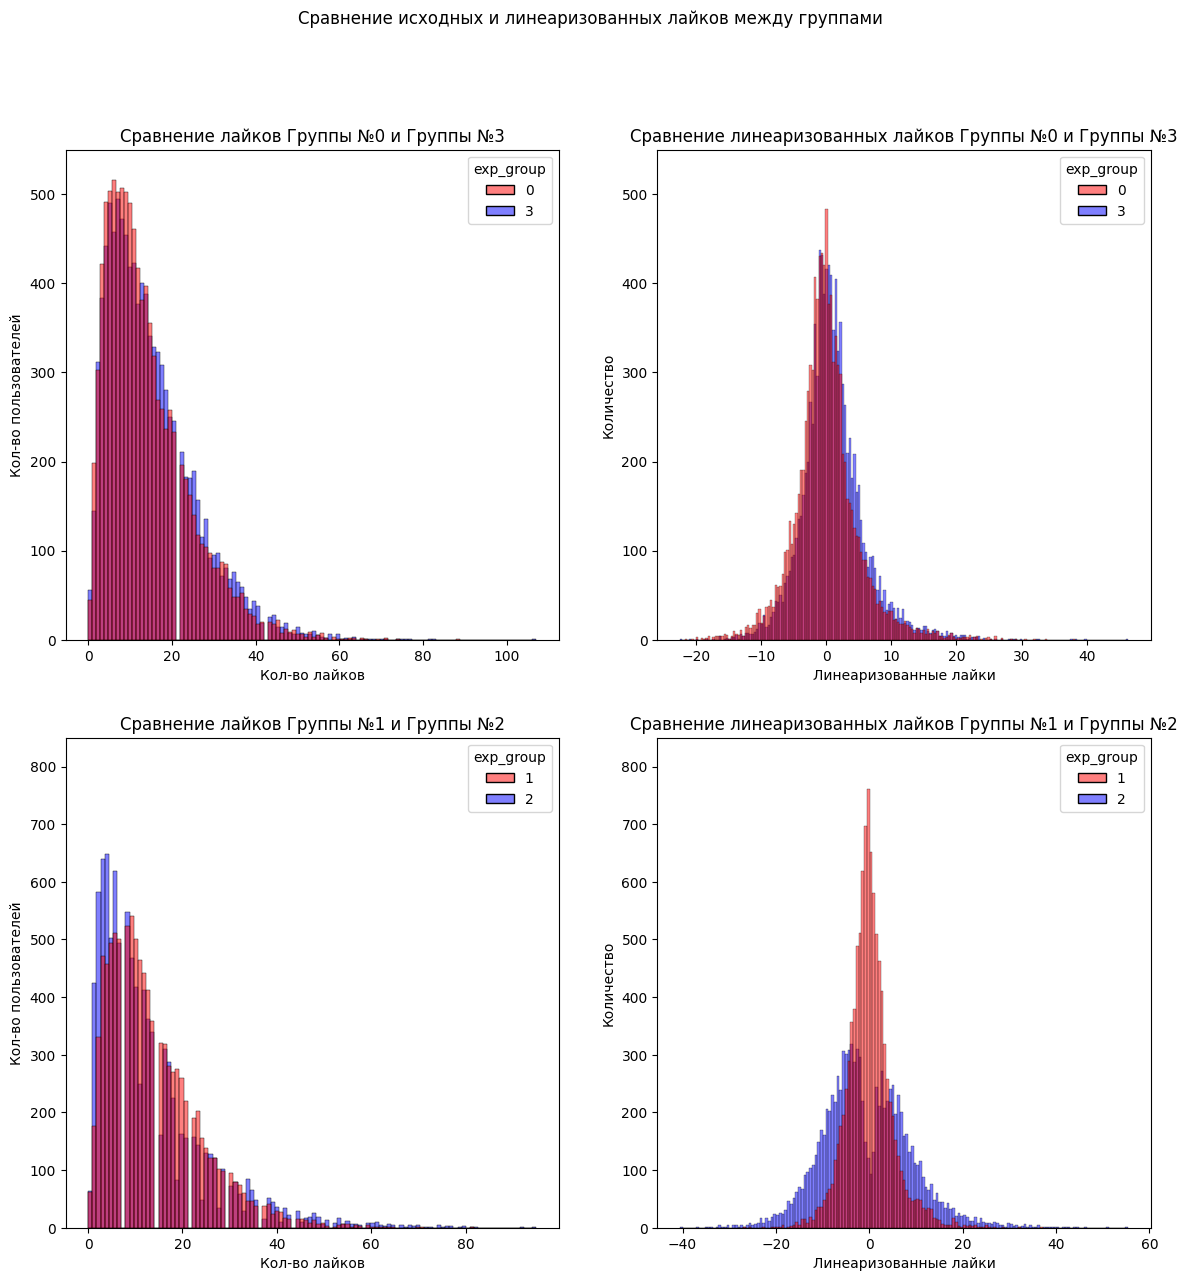

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Сравнение исходных и линеаризованных лайков между группами')



sns.histplot(
    ax = axes[0][0],
    bins = 'auto',
    data = pd.concat([group0_df, group3_df]),
    x = 'likes',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

sns.histplot(
    ax = axes[0][1],
    bins = 'auto',
    data = pd.concat([group0_df, group3_df]),
    x = 'linearized_likes',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

# axes[0].set_xlim(0, 0.9)
axes[0][0].set_ylim(0, 550)
axes[0][0].set_title('Сравнение лайков Группы №0 и Группы №3')
axes[0][0].set_xlabel('Кол-во лайков')
axes[0][0].set_ylabel('Кол-во пользователей')

# axes[1].set_xlim(0, 0.9)
axes[0][1].set_ylim(0, 550)
axes[0][1].set_title('Сравнение линеаризованных лайков Группы №0 и Группы №3')
axes[0][1].set_xlabel('Линеаризованные лайки')
axes[0][1].set_ylabel('Количество')



sns.histplot(
    ax = axes[1][0],
    bins = 'auto',
    data = pd.concat([group1_df, group2_df]),
    x = 'likes',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

sns.histplot(
    ax = axes[1][1],
    bins = 'auto',
    data = pd.concat([group1_df, group2_df]),
    x = 'linearized_likes',
    hue = 'exp_group',
    palette = ['r', 'b'],
    alpha = 0.5,
    kde = False
)

# axes[0].set_xlim(0, 0.9)
axes[1][0].set_ylim(0, 850)
axes[1][0].set_title('Сравнение лайков Группы №1 и Группы №2')
axes[1][0].set_xlabel('Кол-во лайков')
axes[1][0].set_ylabel('Кол-во пользователей')

# axes[1].set_xlim(0, 0.9)
axes[1][1].set_ylim(0, 850)
axes[1][1].set_title('Сравнение линеаризованных лайков Группы №1 и Группы №2')
axes[1][1].set_xlabel('Линеаризованные лайки')
axes[1][1].set_ylabel('Количество')


## Визуализация. Выводы
Мы можем наблюдать что несмотря на то что распределения лайков по форме похожи друг на друга, гистограммы подчеркивают существенные различия между ними.
Особенно ярко эти различия можно увидеть на гистограмме сравнения линеаризованных лайков Группы №1 и Группы №2.
Распределение линеаризованных лайков Группы №1 является одномодальным, в то время как распределение Группы №2 является двухмодальным.

Эти наблюдения позволили нам сформировать следующие предварительные гипотезы:
1) Распределение лайков Группы №0 в среднем стохастически МЕНЬШЕ распределения лайков Группы №3
2) Распределение линеаризованных-лайков Группы №0 в среднем стохастически МЕНЬШЕ распределения линеаризованных-лайков Группы №3
3) Распределение лайков Группы №1 в среднем стохастически БОЛЬШЕ распределения лайков Группы №2
4) Распределение линеаризованных-лайков Группы №1 в среднем стохастически БОЛЬШЕ распределения линеаризованных-лайков Группы №2


# Статистический анализ

In [4]:
group0_likes_shapiro = sp.stats.shapiro(group0_df.likes)
group0_likes_dagostino = sp.stats.normaltest(group0_df.likes)
group0_linearized_likes_shapiro = sp.stats.shapiro(group0_df.linearized_likes)
group0_linearized_likes_dagostino = sp.stats.normaltest(group0_df.linearized_likes)

group3_likes_shapiro = sp.stats.shapiro(group3_df.likes)
group3_likes_dagostino = sp.stats.normaltest(group3_df.likes)
group3_linearized_likes_shapiro = sp.stats.shapiro(group3_df.linearized_likes)
group3_linearized_likes_dagostino = sp.stats.normaltest(group3_df.linearized_likes)

# Т-критерий Стьюдента для независимых выборок
# ГИПОТЕЗА: среднее значение распределения Группы №0
# стохастически МЕНЬШЕ среднего значения распределения Группы №3
# То есть у Группы №0 (контрольной) в среднем лайки ниже чем у Группы №3
likes_ttest = sp.stats.ttest_ind(
    group0_df.likes,
    group3_df.likes,
    equal_var=False,
    alternative='less'
)

# Т-критерий Стьюдента для независимых выборок
# ГИПОТЕЗА: среднее значение распределения Группы №0
# стохастически МЕНЬШЕ среднего значения распределения Группы №3
# То есть у Группы №0 (контрольной) в среднем линеаризованные-лайки ниже чем у Группы №3
linearized_likes_ttest = sp.stats.ttest_ind(
    group0_df.linearized_likes,
    group3_df.linearized_likes,
    equal_var=False,
    alternative='less'
)

# U-критерий Манна-Уитни
# ГИПОТЕЗА: распределение Группы №0 стохастически МЕНЬШЕ распределения Группы №3
# То есть у Группы №0 (контрольной) лайки МЕНЬШЕ чем у Группы №3
likes_mwutest = sp.stats.mannwhitneyu(
    group0_df.likes,
    group3_df.likes,
    alternative = 'less'
)

# U-критерий Манна-Уитни
# ГИПОТЕЗА: распределение Группы №0 стохастически МЕНЬШЕ распределения Группы №3
# То есть у Группы №0 (контрольной) линеаризованные-лайки МЕНЬШЕ чем у Группы №3
linearized_likes_mwutest = sp.stats.mannwhitneyu(
    group0_df.linearized_likes,
    group3_df.linearized_likes,
    alternative = 'less'
)

print("Группа №0, распределение лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group0_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group0_likes_dagostino[1])

print("\nГруппа №0, распределение линеаризованных-лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group0_linearized_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group0_linearized_likes_dagostino[1])

print("\nГруппа №3, распределение лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group3_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group3_likes_dagostino[1])

print("\nГруппа №3, распределение линеаризованных-лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group3_linearized_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group3_linearized_likes_dagostino[1])

print("\nГруппы №0-№3, сравнение лайков:")
print('Т-критерий Стьюдента:   ', likes_ttest[1])
print('U-критерий Манна-Уитни: ', likes_mwutest[1])

print("\nГруппы №0-№3, сравнение линеаризованных-лайков:")
print('Т-критерий Стьюдента:   ', linearized_likes_ttest[1])
print('U-критерий Манна-Уитни: ', linearized_likes_mwutest[1])


Группа №0, распределение лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №0, распределение линеаризованных-лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №3, распределение лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №3, распределение линеаризованных-лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группы №0-№3, сравнение лайков:
Т-критерий Стьюдента:    1.015539769979461e-11
U-критерий Манна-Уитни:  7.117889112571725e-11

Группы №0-№3, сравнение линеаризованных-лайков:
Т-критерий Стьюдента:    2.7457124739845008e-52
U-критерий Манна-Уитни:  5.7586575148932984e-64


/home/manjie/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [5]:
group1_likes_shapiro = sp.stats.shapiro(group1_df.likes)
group1_likes_dagostino = sp.stats.normaltest(group1_df.likes)
group1_linearized_likes_shapiro = sp.stats.shapiro(group1_df.linearized_likes)
group1_linearized_likes_dagostino = sp.stats.normaltest(group1_df.linearized_likes)

group2_likes_shapiro = sp.stats.shapiro(group2_df.likes)
group2_likes_dagostino = sp.stats.normaltest(group2_df.likes)
group2_linearized_likes_shapiro = sp.stats.shapiro(group2_df.linearized_likes)
group2_linearized_likes_dagostino = sp.stats.normaltest(group2_df.linearized_likes)

# Т-критерий Стьюдента для независимых выборок
# Гипотеза: среднее значение распределения Группы №1
# стохастически БОЛЬШЕ среднего значения распределения Группы №2
# То есть у Группы №1 (контрольной) в среднем лайки выше чем у Группы №2
likes_ttest = sp.stats.ttest_ind(
    group1_df.likes,
    group2_df.likes,
    equal_var=False,
    alternative='greater'
)

# Т-критерий Стьюдента для независимых выборок
# Гипотеза: среднее значение распределения Группы №1
# стохастически БОЛЬШЕ среднего значения распределения Группы №2
# То есть у Группы №1 (контрольной) в среднем линеаризованные-лайки выше чем у Группы №2
linearized_likes_ttest = sp.stats.ttest_ind(
    group1_df.linearized_likes,
    group2_df.linearized_likes,
    equal_var=False,
    alternative='greater'
)

# U-критерий Манна-Уитни
# Гипотеза: распределение Группы №1 стохастически БОЛЬШЕ распределения Группы №2
# То есть у Группы №1 (контрольной) лайки выше чем у Группы №2
likes_mwutest = sp.stats.mannwhitneyu(
    group1_df.likes,
    group2_df.likes,
    alternative = 'greater'
)

# U-критерий Манна-Уитни
# Гипотеза: распределение Группы №1 стохастически БОЛЬШЕ распределения Группы №2
# То есть у Группы №1 (контрольной) линеаризованные-лайки выше чем у Группы №2
linearized_likes_mwutest = sp.stats.mannwhitneyu(
    group1_df.linearized_likes,
    group2_df.linearized_likes,
    alternative = 'greater'
)

print("Группа №1, распределение лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group1_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group1_likes_dagostino[1])

print("\nГруппа №1, распределение линеаризованных лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group1_linearized_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group1_linearized_likes_dagostino[1])

print("\nГруппа №2, распределение лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group2_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group2_likes_dagostino[1])

print("\nГруппа №2, распределение линеаризованных лайков, проверка на нормальность:")
print("Критерий Шапиро-Уилка: ", group2_linearized_likes_shapiro[1])
print("Критерий Д'Агостино:   ", group2_linearized_likes_dagostino[1])

print("\nГруппы №1-№2, сравнение лайков:")
print('Т-критерий Стьюдента:   ', likes_ttest[1])
print('U-критерий Манна-Уитни: ', likes_mwutest[1])

print("\nГруппы №1-№2, сравнение линеаризованных лайков:")
print('Т-критерий Стьюдента:   ', linearized_likes_ttest[1])
print('U-критерий Манна-Уитни: ', linearized_likes_mwutest[1])


Группа №1, распределение лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №1, распределение линеаризованных лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    1.0695180447262187e-284

Группа №2, распределение лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  0.0
Критерий Д'Агостино:    0.0

Группа №2, распределение линеаризованных лайков, проверка на нормальность:
Критерий Шапиро-Уилка:  7.070811049574688e-31
Критерий Д'Агостино:    1.6551024574435903e-118

Группы №1-№2, сравнение лайков:
Т-критерий Стьюдента:    3.4881089971377704e-06
U-критерий Манна-Уитни:  1.4300962888572648e-39

Группы №1-№2, сравнение линеаризованных лайков:
Т-критерий Стьюдента:    4.719716093518856e-10
U-критерий Манна-Уитни:  4.702159789820869e-27


## Выводы
Проверка на нормальность продемонстрировала, что ни одно из распределений лайков и линеаризованных-лайков <b>не является нормальным</b>. Это ставит под сомнение валидность использования Т-критерия для сравнения распределений между группами. Тем не менее, мы также приводим результаты Т-критерия для сравнения.

Значения Т-критерия Стьюдента и U-критерия Манна-Уитни однозначно подтвердили все предварительные гипотезы, следовательно мы можем утверждать что:

1) Лайки Группы №0 в среднем стохастически МЕНЬШЕ лайков Группы №3
2) Линеаризованные-лайки Группы №0 в среднем стохастически МЕНЬШЕ линеаризованных-лайков Группы №3
3) Лайки Группы №1 в среднем стохастически БОЛЬШЕ лайков Группы №2
4) Линеаризованные-лайки Группы №1 в среднем стохастически БОЛЬШЕ линеаризованных-лайков Группы №2

Также при сравнении Групп №0 и Групп №3 мы можем наблюдать, что при переходе от лайков к линеаризованным-лайкам значения Т-критерия Стьюдента и U-критерия Манна-Уитни уменьшаются.
При сравнении Групп №1 и Групп №2 мы можем наблюдать, что при переходе от лайков к линеаризованным-лайкам значения Т-критерия Стьюдента уменьшаются, а значения U-критерия Манна-Уитни увеличиваются.
Из этого мы можем предположить что Т-критерий Стьюдента уменьшает свое значение, в то время как U-критерий Манна-Уитни не демонстрирует настолько однозначного поведения.